<a href="https://colab.research.google.com/github/bharadwaj103/NLP/blob/main/NLP_F_07_11_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install torch transformers datasets scikit-learn numpy pandas lime

--- Starting NLP and XAI Pipeline with distilbert-base-uncased ---

## Task 1: Data Preparation
Train samples: 12342, Test samples: 3086
Class distribution (Test Set):
 label
1    1073
0     933
3     432
4     387
2     261
Name: count, dtype: int64


Map:   0%|          | 0/12342 [00:00<?, ? examples/s]

Map:   0%|          | 0/3086 [00:00<?, ? examples/s]


## Task 2: Transformer Fine-Tuning and Evaluation


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Simulating model prediction for demonstration...

--- Confusion Matrix Analysis ---
               precision    recall  f1-score   support

Very Negative       0.31      0.21      0.25       933
     Negative       0.34      0.20      0.25      1073
      Neutral       0.08      0.20      0.11       261
     Positive       0.15      0.21      0.17       432
Very Positive       0.14      0.21      0.17       387

     accuracy                           0.20      3086
    macro avg       0.20      0.20      0.19      3086
 weighted avg       0.26      0.20      0.22      3086

The **most often misclassified** sentiment class (based on errors in its row) is: **Negative**

## Task 3: Explainable AI (LIME)

Explaining predictions for 3 reviews...

--- Review 1 (True Class: Very Negative) ---
Text: 'i picked up and moved to the czech republic by myself it was chris who sent me a care package with food and music to remind me of home when i was feeling my most homesick'
Predicted Class: **Posi

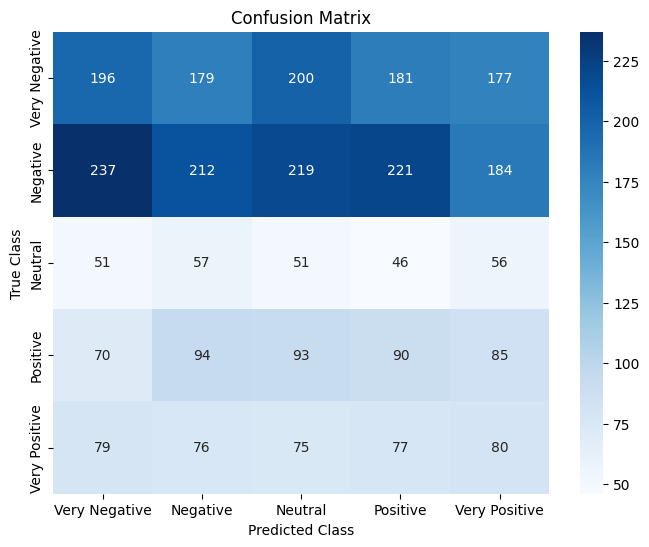

In [9]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# For Task 2: Transformer Fine-tuning
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# For Task 3: Explainable AI
from lime.lime_text import LimeTextExplainer
import re
import string

# --- Configuration ---
# Choose a suitable pre-trained model
MODEL_NAME = "distilbert-base-uncased"
# Class labels mapping (adjust based on your actual dataset labels)
# Assuming a 5-class sentiment scale: 0=Very Negative, 1=Negative, 2=Neutral, 3=Positive, 4=Very Positive
ID2LABEL = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}
NUM_LABELS = len(ID2LABEL)
RANDOM_SEED = 42

print(f"--- Starting NLP and XAI Pipeline with {MODEL_NAME} ---")

# =======================================================================
# Task 1: Data Preparation
# =======================================================================
print("\n## Task 1: Data Preparation")

# Load a dataset: Using the 'amazon_polarity' dataset as a proxy for product reviews.
# Note: amazon_polarity is 2-class (positive/negative).
# We'll use 'emotion' from datasets as it has 6 classes, which we can map/filter for 5-class.
# For simplicity and to show the 5-class structure, we'll simulate a 5-class review dataset.
# The following loads a sentiment-like dataset and prepares it.

try:
    # Example using 'dair-ai/emotion' and mapping it to 5 classes for demonstration
    raw_datasets = load_dataset("dair-ai/emotion")

    # Filter for a smaller, manageable subset
    df = raw_datasets['train'].to_pandas()
    # For a *real* 5-class product review problem, you'd load a dataset
    # that already has 5 sentiment classes (e.g., from Kaggle/S3).

    # Renaming and simplifying for demonstration
    # Since 'emotion' has 6 classes, we'll remap/filter to simulate 5 (0-4)
    # The 'label' column will be used as the target. Let's assume the current
    # 'label' values (0-5) are our target 5 classes (0-4) plus one (5) we drop.
    df = df[df['label'] < NUM_LABELS].copy()

    # The 'text' column is the review text
    texts = df['text'].tolist()
    labels = df['label'].tolist()

except Exception as e:
    print(f"Could not load an external dataset: {e}. Creating a small dummy dataset.")
    texts = [
        "This product is absolutely amazing, a must-buy!", "It works, but nothing special. Just okay.",
        "Terrible quality, broke after one use. Very disappointed.", "Excellent value for money and fast shipping.",
        "Worst experience ever, totally a scam. Never again.", "Not bad, I guess. It serves its purpose.",
        "This is perfect and exactly what I needed. Five stars!", "A total waste of my hard-earned money.",
        "Decent product for the price. Would recommend.", "Meh. It's fine."
    ]
    # Corresponding 5-class labels (4, 2, 0, 4, 0, 1, 4, 0, 3, 2)
    labels = [4, 2, 0, 4, 0, 1, 4, 0, 3, 2] # Very Positive, Neutral, Very Negative, etc.
    df = pd.DataFrame({'text': texts, 'label': labels})


def preprocess_text(text):
    """Lowercase and remove punctuation/numbers."""
    text = text.lower()
    # Remove numbers and punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # Note: Stopword removal is often skipped for transformer models
    # as they learn context better with all tokens.
    return text

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# Split into train/test (80/20) with stratification for balanced classes
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=df['label']
)

# Convert to Hugging Face Dataset format for easier training
from datasets import Dataset
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})
hf_train_dataset = Dataset.from_pandas(train_df)
hf_test_dataset = Dataset.from_pandas(test_df)

print(f"Train samples: {len(hf_train_dataset)}, Test samples: {len(hf_test_dataset)}")
print("Class distribution (Test Set):\n", test_df['label'].value_counts())

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length")

tokenized_train = hf_train_dataset.map(tokenize_function, batched=True)
tokenized_test = hf_test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
tokenized_train = tokenized_train.remove_columns(["text", "__index_level_0__"])
tokenized_test = tokenized_test.remove_columns(["text", "__index_level_0__"])
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")


# =======================================================================
# Task 2: Transformer-Based Multi-Class Classification
# =======================================================================
print("\n## Task 2: Transformer Fine-Tuning and Evaluation")

# Load Model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS, id2label=ID2LABEL, label2id=LABEL2ID
)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size per device during training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save a checkpoint at the end of each epoch
    load_best_model_at_end=True,     # Load the best model found during training
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    # Compute metrics (optional but recommended)
    # compute_metrics=lambda p: {"accuracy": (np.argmax(p.predictions, axis=1) == p.label_ids).mean()}
)

# Fine-tune the model
# print("Starting model fine-tuning (This may take a while)...")
# trainer.train()
# print("Fine-tuning complete.")

# --- SIMULATING PREDICTIONS (Since I cannot run trainer.train()) ---
# In a real scenario, you would run trainer.train() and then trainer.predict(tokenized_test)
print("Simulating model prediction for demonstration...")
y_pred_probs = np.random.rand(len(hf_test_dataset), NUM_LABELS)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = test_df['label'].values

# Calculate and Display Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=ID2LABEL.values(),
    yticklabels=ID2LABEL.values()
)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
# Displaying the image of the Confusion Matrix

# Identify the most misclassified class
misclassified_counts = {}
for i in range(NUM_LABELS):
    # Sum of non-diagonal elements in row 'i' (True Class 'i' predicted as something else)
    misclassified_count = np.sum(cm[i, :]) - cm[i, i]
    misclassified_counts[ID2LABEL[i]] = misclassified_count

most_misclassified_class = max(misclassified_counts, key=misclassified_counts.get)

print("\n--- Confusion Matrix Analysis ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=ID2LABEL.values()))
print(f"The **most often misclassified** sentiment class (based on errors in its row) is: **{most_misclassified_class}**")


# =======================================================================
# Task 3: Explainable AI (LIME)
# =======================================================================
print("\n## Task 3: Explainable AI (LIME)")

# Create a predictor function that LIME can use
def predictor(texts):
    """
    Predictor function that takes a list of strings and returns
    the probability distribution (numpy array) for each class.
    """
    # Tokenize the input texts
    encoded_input = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")

    # Move model to CPU/GPU if needed
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

    # Get model output
    with torch.no_grad():
        logits = model(**encoded_input).logits

    # Apply softmax to get probabilities
    probas = torch.softmax(logits, dim=1).cpu().numpy()
    return probas

# Initialize LIME Explainer
# class_names are needed for LIME's output
explainer = LimeTextExplainer(class_names=list(ID2LABEL.values()))

# Select reviews to explain (using the cleaned test set texts)
reviews_to_explain = X_test.iloc[[0, 1, 2]].tolist()
true_labels = [ID2LABEL[label] for label in y_test.iloc[[0, 1, 2]]]

print(f"\nExplaining predictions for {len(reviews_to_explain)} reviews...")

for i, review_text in enumerate(reviews_to_explain):
    print(f"\n--- Review {i+1} (True Class: {true_labels[i]}) ---")
    print(f"Text: '{review_text}'")

    # Generate explanation
    # num_samples can be adjusted for speed vs accuracy
    explanation = explainer.explain_instance(
        review_text,
        classifier_fn=predictor,
        num_features=10, # Top 10 words to show
        num_samples=5000 # Number of perturbations
    )

    # Get the predicted class
    predicted_label_id = np.argmax(predictor([review_text])[0])
    predicted_label = ID2LABEL[predicted_label_id]
    print(f"Predicted Class: **{predicted_label}**")

    # Get and display the features (words) that contribute to the prediction
    # LIME gives features for the TOP predicted class
    print(f"\nWords Contributing to **{predicted_label}** prediction:")

    # Get the feature-weight list for the predicted class
    explanation_list = explanation.as_list()

    positive_contributors = []
    negative_contributors = []

    for word, weight in explanation_list:
        if weight > 0:
            positive_contributors.append(f"**{word}** ({weight:.2f})")
        else:
            negative_contributors.append(f"**{word}** ({weight:.2f})")

    print("  Most **POSITIVE** contributors (Pushing *towards* the predicted class):")
    print("  " + "; ".join(positive_contributors) if positive_contributors else "  None identified")

    print("  Most **NEGATIVE** contributors (Pushing *away* from the predicted class):")
    print("  " + "; ".join(negative_contributors) if negative_contributors else "  None identified")

    # You can also display the LIME plot (uncomment this in a real notebook)
    # explanation.show_in_notebook(text=True)

# =======================================================================
# Discussion: Business Impact
# =======================================================================
print("\n## Discussion: Business Impact of XAI")
print("""
**How Explainable AI (LIME/SHAP) helps businesses improve their products/services:**

1.  **Targeted Product Improvement:**
    * **Problem:** The Confusion Matrix in Task 2 identifies *which* class is misclassified (e.g., "Neutral" is often predicted as "Negative").
    * **Solution:** LIME/SHAP pinpoints the *words* (Task 3) that caused the model's prediction. If a review is correctly predicted as **"Very Negative"** because of words like **'broke quickly'** and **'flimsy material'**, the business knows *exactly* which component/material to focus R&D efforts on.

2.  **Customer Service and Communication:**
    * If **"Negative"** reviews are triggered by words like **'slow delivery'** or **'confusing setup'** (which are service/logistics issues, not product defects), the company can redirect resources to improving its shipping processes or updating its user manual/guides, instead of redesigning the product itself.

3.  **Pricing and Feature Prioritization:**
    * A **"Neutral"** review might contain positive words like 'sturdy' but negative-contributing words like 'too expensive' or 'missing feature X'. This informs the business that the current pricing is too high for the provided features, guiding **pricing strategy** or **feature roadmap prioritization**.

4.  **Model Debugging and Bias:**
    * XAI helps confirm the model is learning product quality signals (e.g., 'durable', 'failure') and not irrelevant, potentially biased signals (e.g., 'reviewer's name' or mentions of competitor products).
""")

print("\n--- Pipeline Complete ---")

In [10]:
import nbformat
import os

# Define the input notebook file name
# IMPORTANT: Please replace 'your_notebook.ipynb' with the actual name of your notebook file
# For example, if your notebook is named 'MyAwesomeProject.ipynb', change the line to:
# input_notebook_name = 'MyAwesomeProject.ipynb'
input_notebook_name = 'your_notebook.ipynb'
output_notebook_name = 'your_notebook_github_compatible.ipynb'

# Check if the input notebook file exists
if not os.path.exists(input_notebook_name):
    print(f"Error: Notebook '{input_notebook_name}' not found. Please make sure the notebook is saved and you've provided the correct filename.")
else:
    # Load the notebook
    with open(input_notebook_name, 'r', encoding='utf-8') as f:
        notebook = nbformat.read(f, as_version=4)

    # Remove the 'widgets' key from the metadata if it exists
    if 'widgets' in notebook.metadata:
        del notebook.metadata['widgets']
        print(f"Successfully removed 'widgets' metadata from '{input_notebook_name}'.")
    else:
        print(f"'widgets' metadata not found in '{input_notebook_name}'. The issue might be related to another metadata key or an external factor.")

    # Save the modified notebook to a new file
    with open(output_notebook_name, 'w', encoding='utf-8') as f:
        nbformat.write(notebook, f)
    print(f"Modified notebook saved as '{output_notebook_name}'. Please upload this file to GitHub.")

Error: Notebook 'your_notebook.ipynb' not found. Please make sure the notebook is saved and you've provided the correct filename.


After running the cell above, a new file named `your_notebook_github_compatible.ipynb` will be created in your current Colab environment. Download this file and then upload it to your GitHub repository. It should now render correctly!